In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# move to the target folder and listing the content
%cd /content/drive/MyDrive/Machine_Learning/
!ls

/content/drive/MyDrive/Machine_Learning
1_image_facial_recognition_basic.ipynb				    5_object_detection_YOLOv8.ipynb
2_image_facial_analysis_recognition_DeepFace.ipynb		    Images
3_live_webcam_facial_landmarks_CNN.ipynb			    Models
4a_live_webcam_facial_landmarks_drowsiness_detection_MTCNN.ipynb    sound
4b_live_webcam_facial_landmarks_drowsiness_detection_DlibCNN.ipynb


In [2]:
!pip install ultralytics

In [41]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import cv2
import numpy as np
import PIL
import io


In [ ]:
# Google funcion to capture a photo from the webcam
def take_photo(filename='Images/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [24]:
# load the YOLO pretrained model
model = YOLO('Models/yolov8n.pt')

In [27]:
def predict(filename):
  results = model(filename, verbose=False)

  # plots the detection results
  annotated_image = results[0].plot()

  # show the image
  cv2_imshow(annotated_image)

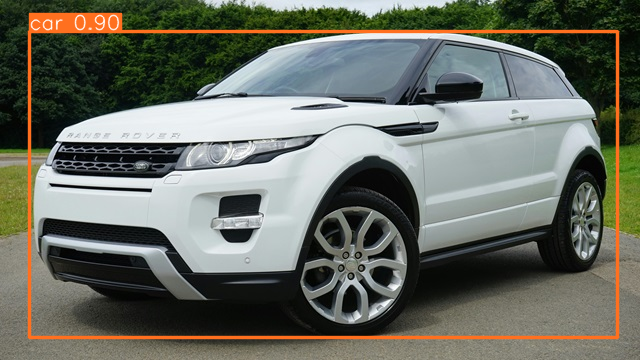

In [33]:
# Predict objects
predict('./Images/objects1.jpg')

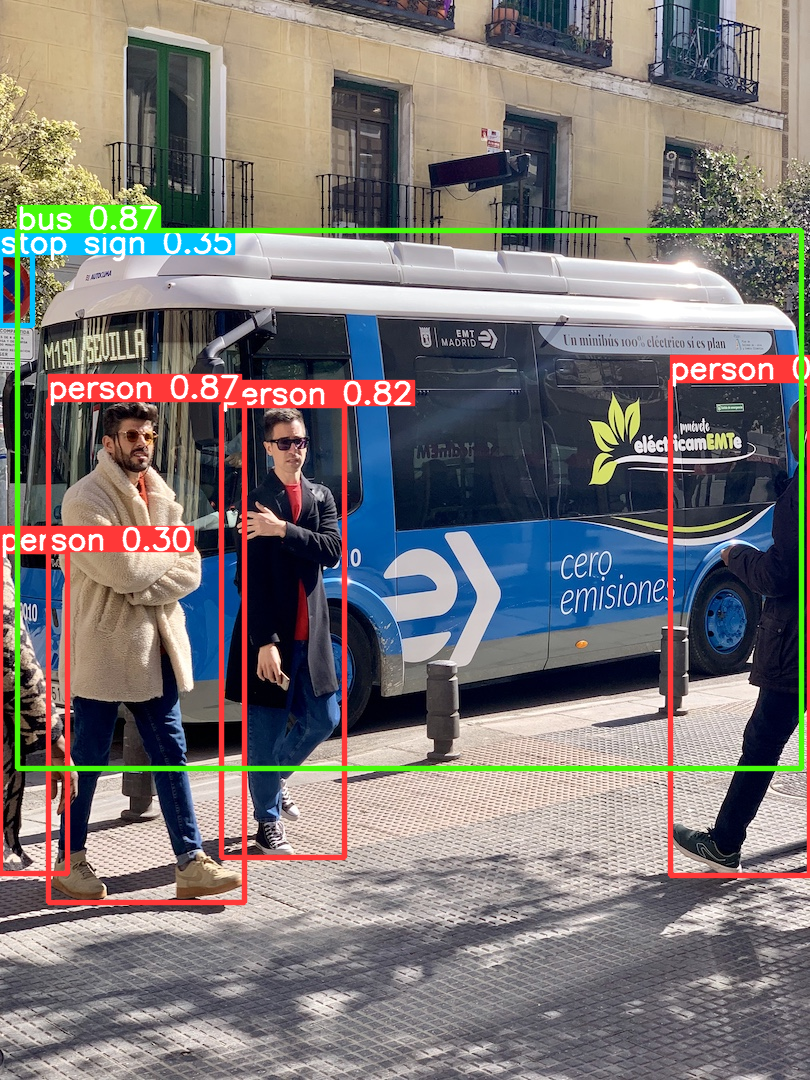

In [34]:
# Predict objects
predict('./Images/objects2.jpg')

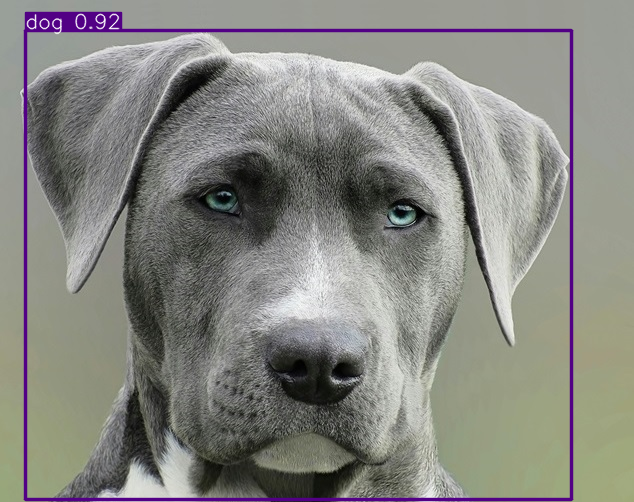

In [35]:
# Predict objects
predict('./Images/objects5.jpg')

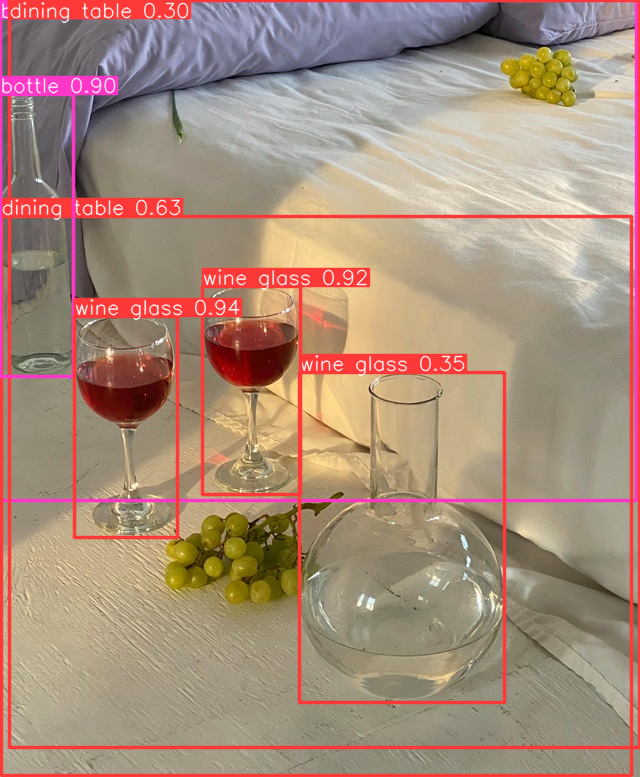

In [36]:
# Predict objects
predict('./Images/objects4.jpg')

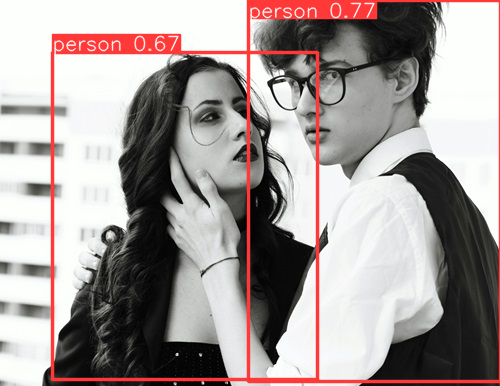

In [37]:
# Predict objects
predict('./Images/faces1.jpg')

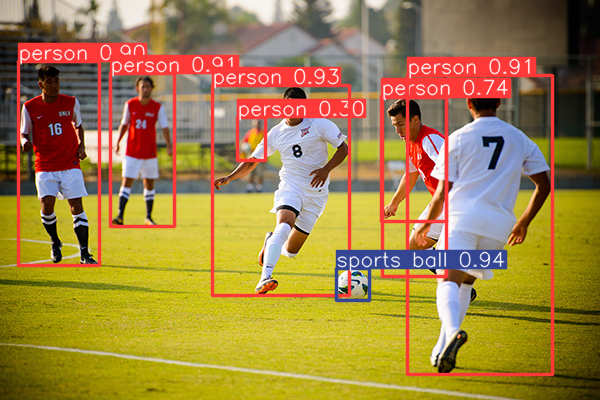

In [38]:
# Predict objects
predict('./Images/objects6.jpg')

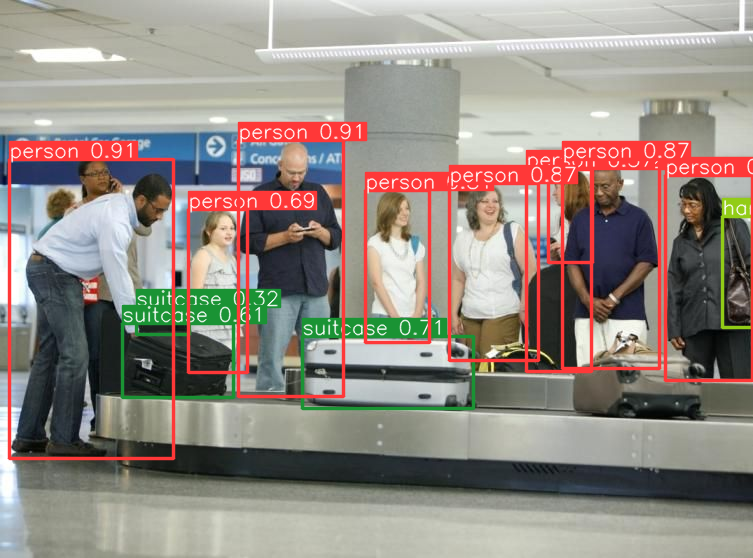

In [39]:
# Predict objects
predict('./Images/objects7.jpg')

<IPython.core.display.Javascript object>


image 1/1 /content/drive/MyDrive/Machine_Learning/Images/photo.jpg: 480x640 1 person, 1 cell phone, 170.9ms
Speed: 2.4ms preprocess, 170.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


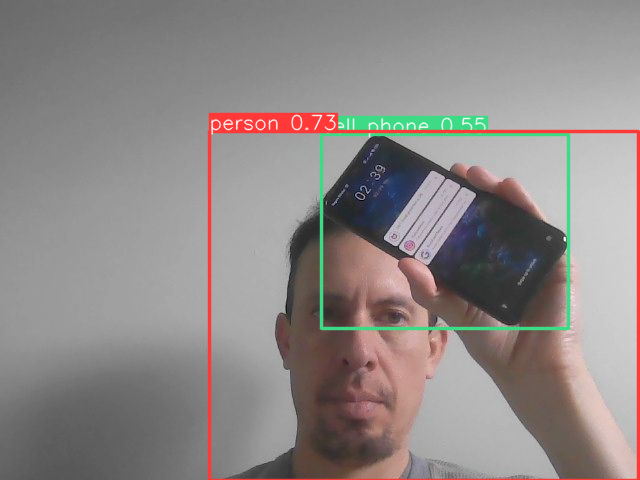

In [ ]:
# Capture the photo
image_photo = take_photo()

# Predict objects
predict(image_photo)

In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [42]:
# initialize the video stream and pointer to output video file, then
# allow the camera sensor to warm up
print("Starting video stream...")
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

# loop over frames from the video file stream
while True:
      js_reply = video_frame(label_html, bbox)

      if not js_reply:
        break

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      # convert JS response to OpenCV Image
      frame_image = js_to_image(js_reply["img"])

      results = model(frame_image)

      # Process results list
      for result in results:
          for box in result.boxes:
            c = box.xyxy.tolist()[0]
            x2 = int(c[2])
            x1 = int(c[0])
            y2 = int(c[3])
            y1 = int(c[1])

            bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)

            label = result.names[int(box.cls)]
            confidence = float(box.conf.cpu())
            text = f"{label:s}: {confidence:.2f}"
            bbox_array = cv2.putText(bbox_array, text,(x1, y1-5),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (150, 255, 230), 2, cv2.LINE_AA)

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

# do a bit of cleanup
cv2.destroyAllWindows()

Starting video stream...


<IPython.core.display.Javascript object>